# 🗣️ Text-to-Speech (TTS): Architektura Tacotron

Synteza mowy to problem **Sequence-to-Sequence**.
*   Wejście: Sekwencja liter (krótka, np. 20 znaków).
*   Wyjście: Sekwencja klatek audio (długa, np. 200 ramek spektrogramu).

**Architektura:**
1.  **Encoder (Text):** Przetwarza tekst i wyciąga z niego kontekst.
2.  **Attention (Alignment):** Kluczowy element. Decyduje, którą literę teraz "wymawiamy". W TTS uwaga musi przesuwać się płynnie od lewej do prawej (Monotonic Alignment).
3.  **Decoder (Audio):** Generuje spektrogram klatka po klatce (autoregresyjnie), patrząc na to, co wygenerował wcześniej.

Zbudujemy uproszczony model **Mini-Tacotron**.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Wymiary
VOCAB_SIZE = 30   # Alfabet (a-z + znaki spec)
EMBED_DIM = 64    # Wektor dla litery
ENC_HIDDEN = 128  # Pamięć Encodera
DEC_HIDDEN = 128  # Pamięć Decodera
MEL_CHANNELS = 80 # Wysokość spektrogramu (standard w TTS)

print(f"Urządzenie: {DEVICE}")

Urządzenie: cuda


## Krok 1: Encoder (Czytanie tekstu)

Encoder to zazwyczaj warstwa konwolucyjna (żeby widzieć sąsiadujące litery, np. "dzi", "sz") + Bi-directional LSTM.
Dla uproszczenia zrobimy samo **Embedding + LSTM**.

In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, EMBED_DIM)
        # Bidirectional = True, bo chcemy znać kontekst z obu stron zdania
        self.lstm = nn.LSTM(EMBED_DIM, ENC_HIDDEN, batch_first=True, bidirectional=True)

    def forward(self, text_inputs):
        # text_inputs: [Batch, Text_Len]
        embedded = self.embedding(text_inputs)
        
        # outputs: [Batch, Text_Len, ENC_HIDDEN * 2] (bo 2 kierunki)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs

print("Encoder zdefiniowany.")

Encoder zdefiniowany.


## Krok 2: Attention (Dopasowanie Czasu)

W każdej milisekundzie generowania dźwięku, Decoder musi wiedzieć, na którą literę patrzeć.
Użyjemy prostego mechanizmu uwagi (Dot Product Attention).

Wytrenowany model TTS tworzy na mapie uwagi charakterystyczną **przekątną linię** (zaczynamy od początku zdania i idziemy do końca).

In [3]:
class Attention(nn.Module):
    def __init__(self, enc_dim, dec_dim):
        super().__init__()
        self.attn = nn.Linear(enc_dim * 2 + dec_dim, dec_dim)
        self.v = nn.Linear(dec_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [Batch, Dec_Hidden] (Stan obecny Decodera)
        # encoder_outputs: [Batch, Text_Len, Enc_Hidden*2] (Cały tekst)
        
        batch_size = encoder_outputs.shape[0]
        seq_len = encoder_outputs.shape[1]
        
        # Powielamy stan ukryty decodera dla każdej litery, żeby je porównać
        hidden_expanded = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        
        # Sklejamy stan Decodera z literami
        combined = torch.cat((hidden_expanded, encoder_outputs), dim=2)
        
        # Liczymy energię (Score)
        energy = torch.tanh(self.attn(combined))
        attention_weights = F.softmax(self.v(energy), dim=1)
        
        # Context vector: Ważona suma liter
        # [Batch, 1, Seq_Len] x [Batch, Seq_Len, Enc_Dim*2]
        context = torch.bmm(attention_weights.transpose(1, 2), encoder_outputs)
        
        return context, attention_weights.squeeze(2)

print("Mechanizm Uwagi zdefiniowany.")

Mechanizm Uwagi zdefiniowany.


## Krok 3: Decoder (Generowanie Spektrogramu)

Decoder działa w pętli.
1.  Bierze **ostatnią wygenerowaną klatkę audio** (w treningu bierzemy prawdziwą - Teacher Forcing).
2.  Bierze **kontekst z Attention** (którą literę czytamy?).
3.  LSTM przetwarza te dane.
4.  Warstwa liniowa przewiduje **nową klatkę** (80 liczb - mel channels).

In [4]:
class TacotronSimple(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.attention = Attention(ENC_HIDDEN, DEC_HIDDEN)
        
        # Decoder LSTM
        # Wejście: Poprzednia klatka Audio (80) + Kontekst tekstu (256)
        self.decoder_rnn = nn.LSTM(MEL_CHANNELS + (ENC_HIDDEN * 2), DEC_HIDDEN, batch_first=True)
        
        # Projekcja na spektrogram
        self.mel_out = nn.Linear(DEC_HIDDEN, MEL_CHANNELS)

    def forward(self, text, target_mels=None, teacher_forcing_ratio=1.0):
        batch_size = text.shape[0]
        
        # Jeśli mamy cel (trening), to znamy długość. Jak nie (inference), ustalamy max.
        max_len = target_mels.shape[1] if target_mels is not None else 100
        
        # 1. Kodujemy tekst
        enc_outputs = self.encoder(text)
        
        # Stan początkowy decodera
        dec_hidden = torch.zeros(1, batch_size, DEC_HIDDEN).to(DEVICE)
        dec_cell = torch.zeros(1, batch_size, DEC_HIDDEN).to(DEVICE)
        
        # Pierwsza klatka to cisza (zera)
        dec_input = torch.zeros(batch_size, 1, MEL_CHANNELS).to(DEVICE)
        
        outputs = []
        attn_maps = []
        
        for t in range(max_len):
            # A. Policz Attention (Na co patrzymy?)
            # Bierzemy ostatni stan ukryty (squeeze usuwa wymiar warstw)
            context, attn_weights = self.attention(dec_hidden.squeeze(0), enc_outputs)
            
            # B. Przygotuj wejście do RNN: [Klatka Audio, Kontekst Tekstowy]
            rnn_input = torch.cat((dec_input, context), dim=2)
            
            # C. Krok LSTM
            out, (dec_hidden, dec_cell) = self.decoder_rnn(rnn_input, (dec_hidden, dec_cell))
            
            # D. Przewiduj nową klatkę Mel
            mel_frame = self.mel_out(out)
            outputs.append(mel_frame)
            attn_maps.append(attn_weights)
            
            # E. Przygotuj wejście na następny krok
            if target_mels is not None and torch.rand(1).item() < teacher_forcing_ratio:
                # Teacher Forcing: Użyj prawdziwej klatki
                dec_input = target_mels[:, t:t+1, :]
            else:
                # Autoregresja: Użyj tego, co sam wygenerowałeś
                dec_input = mel_frame
                
        return torch.cat(outputs, dim=1), torch.stack(attn_maps, dim=1)

model = TacotronSimple().to(DEVICE)
print(model)

TacotronSimple(
  (encoder): Encoder(
    (embedding): Embedding(30, 64)
    (lstm): LSTM(64, 128, batch_first=True, bidirectional=True)
  )
  (attention): Attention(
    (attn): Linear(in_features=384, out_features=128, bias=True)
    (v): Linear(in_features=128, out_features=1, bias=False)
  )
  (decoder_rnn): LSTM(336, 128, batch_first=True)
  (mel_out): Linear(in_features=128, out_features=80, bias=True)
)


Wejście (Tekst): torch.Size([1, 10])
Wyjście (Mel):   torch.Size([1, 50, 80]) -> Oczekiwaliśmy [1, 50, 80]


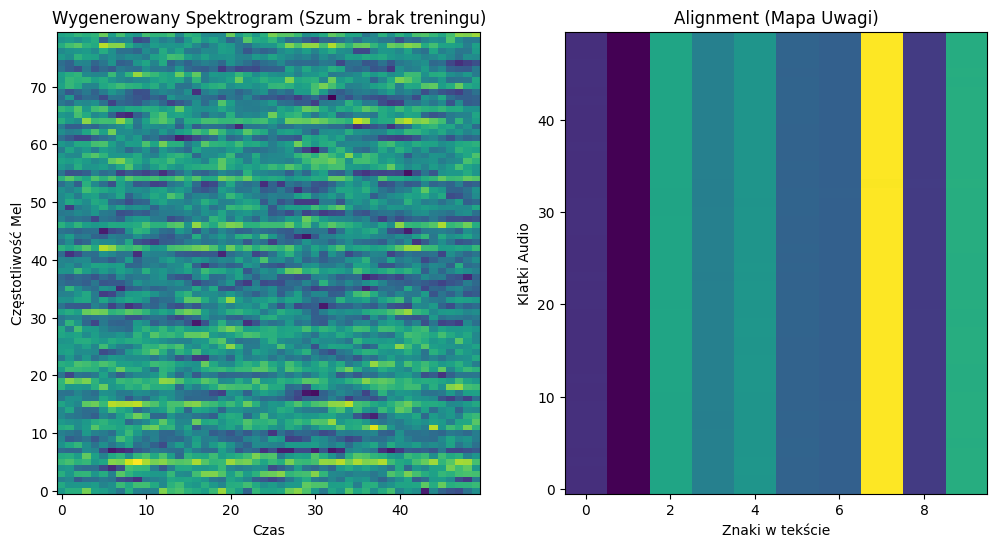

In [5]:
# TEST DZIAŁANIA (Forward Pass)

# 1. Symulujemy dane
# Tekst: "Hello" -> [8, 5, 12, 12, 15] (tokeny)
text_input = torch.randint(0, VOCAB_SIZE, (1, 10)).to(DEVICE) # Batch=1, Długość tekstu=10

# Symulujemy "Prawdziwy" spektrogram (dla treningu)
# Batch=1, Długość audio=50 ramek, 80 kanałów
target_mel = torch.randn(1, 50, MEL_CHANNELS).to(DEVICE)

# 2. Uruchamiamy model
output_mel, attention_plot = model(text_input, target_mel)

print(f"Wejście (Tekst): {text_input.shape}")
print(f"Wyjście (Mel):   {output_mel.shape} -> Oczekiwaliśmy [1, 50, 80]")

# 3. Wizualizacja (Co wypluł nietrenowany model?)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(output_mel[0].detach().cpu().numpy().T, aspect='auto', origin='lower')
plt.title("Wygenerowany Spektrogram (Szum - brak treningu)")
plt.ylabel("Częstotliwość Mel")
plt.xlabel("Czas")

plt.subplot(1, 2, 2)
# Mapa uwagi: Oś X (Tekst), Oś Y (Czas Audio)
plt.imshow(attention_plot[0].detach().cpu().numpy(), aspect='auto', origin='lower')
plt.title("Alignment (Mapa Uwagi)")
plt.xlabel("Znaki w tekście")
plt.ylabel("Klatki Audio")

plt.show()

## 🧠 Podsumowanie: Gdzie jest dźwięk?

Widzisz te dwa obrazki?
1.  **Spektrogram:** Na razie wygląda jak szum, bo wagi są losowe. Po treningu zobaczyłbyś poziome paski (formanty mowy).
2.  **Attention:** Na razie jest rozmyte. Po treningu zobaczyłbyś wyraźną **linię po przekątnej**.
    *   Klatka audio 0 patrzy na literę 0.
    *   Klatka audio 10 patrzy na literę 2.
    *   ...itd.

**Co dalej? (Vocoder)**
Ten model wypluwa obrazek (Mel-Spectrogram 80 kanałów).
Żeby usłyszeć głos, musisz ten obrazek wrzucić do **Vocodera** (np. HiFi-GAN), który zamieni te 80 liczb na 22 050 próbek fali na sekundę.